<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Transfer_learning_and_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

## Transfer learning and Fine tuning
**How to classify images of cats and dogs by using transfer learning from a pre-trained network**.

A **pre-trained model** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

**Two ways to customize a pretrained model:**

* **Feature Extraction**: Use the representations learned by a previous network (trained network) to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

* **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

**General machine learning workflow**.

* Examine and understand the data
* Build an input pipeline
* Compose the model
* Load in the pretrained base model (and pretrained weights)
* Stack the classification layers on top
* Train the model
* Evaluate model

## Data preprocessing
**Data download**

Download the dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory utility`. 

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

dataset_dir = tf.keras.utils.get_file('cats_and_dogs', origin=URL, extract=True, cache_dir='.', cache_subdir='')

68608000/68606236 [==============================] - 1s 0us/step


In [3]:
dataset_parent_dir = pathlib.Path(dataset_dir).parent
print('parent directory : ',dataset_parent_dir )
for directory in dataset_parent_dir.iterdir():
  print('directory : ',directory)

cats_and_dogs = dataset_parent_dir/'cats_and_dogs_filtered'
print('\nTraining and Validation dataset \n')
for directory in cats_and_dogs.iterdir():
  print('directory : ',directory)

parent directory :  .
directory :  .config
directory :  cats_and_dogs
directory :  cats_and_dogs_filtered
directory :  sample_data

Training and Validation dataset 

directory :  cats_and_dogs_filtered/vectorize.py
directory :  cats_and_dogs_filtered/validation
directory :  cats_and_dogs_filtered/train


In [4]:
train_dir = cats_and_dogs/'train'
val_dir = cats_and_dogs/'validation'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


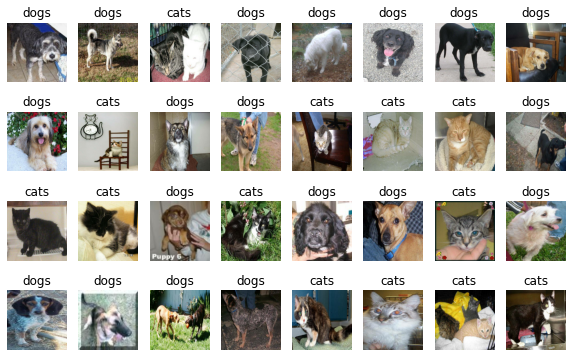

In [5]:
image_batch, label_batch = next(iter(raw_train_ds))
plt.figure(figsize=(10,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'));
  plt.axis('off')
  plt.title(raw_train_ds.class_names[label_batch.numpy()[i]])
  plt.subplots_adjust(top=0.6)

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [6]:
val_batches = raw_val_ds.cardinality().numpy()
print('Batches in validation set', val_batches)
print('** Creating a test-set **')
raw_test_ds = raw_val_ds.take(val_batches//5)
raw_val_ds = raw_val_ds.skip(val_batches//5)

print('Batches in validation set', raw_val_ds.cardinality().numpy())
print('Batches in test set', raw_test_ds.cardinality().numpy())

Batches in validation set 32
** Creating a test-set **
Batches in validation set 26
Batches in test set 6


## Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

**Note: These layers are active only during training, when you call model.fit. They are inactive when the model is used in inference mode in model.evaulate or model.fit.**

In [7]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.1)
])

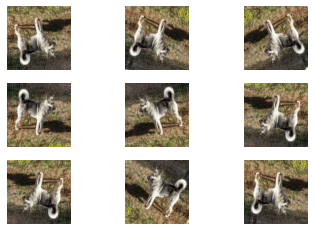

In [8]:
for i in range(9):
  plt.subplot(3,3,i+1)
  image = tf.expand_dims(image_batch[1], 0)
  augmentation = data_augmentation(image)
  plt.imshow(augmentation[0].numpy().astype('uint8'))
  plt.axis('off')

## Rescale pixel values
`tf.keras.applications.MobileNetV2` is the base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using a Rescaling layer.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# rescaling layer
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=0.1/127.5, offset=-1)

## Feature Extraction : base model/Pre-trained convnets
**Create the base model from the pre-trained convnets**

The base model is created from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer is not very useful. Instead, we'll will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, **you load a network that doesn't include the classification layers at the top**, which is ideal for feature extraction.

In [11]:
# Create the base model from the pre-trained model MobileNet V2

base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts each`160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [12]:
image = image_batch[0]
print('shape of image passed as input',tf.expand_dims(image,0).shape)
feature_block = base_model(tf.expand_dims(image,0))
print('shape of feature block output by the model',feature_block.shape)

shape of image passed as input (1, 160, 160, 3)
shape of feature block output by the model (1, 5, 5, 1280)


**Feature extraction**

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

**Freeze the convolutional base**

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [13]:
base_model.trainable = False

Important note about **BatchNormalization layers**

Many models contain `tf.keras.layers.BatchNormalization layers`. This layer is a special case and precautions should be taken in the context of fine-tuning.

**When you set `layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics**.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

## Model building

**Add a classification head**

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single `1280-element vector `per image.

In [14]:
image = tf.expand_dims(image_batch[0],0)
print('Shape of input image',image.shape)
feature_block = base_model(image)
print('Shape of model output features', feature_block.shape)
feature_batch_average = tf.keras.layers.GlobalAvgPool2D()(feature_block)
print('Shape of average output',feature_batch_average.shape)

Shape of input image (1, 160, 160, 3)
Shape of model output features (1, 5, 5, 1280)
Shape of average output (1, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value.

Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
global_average_layer = tf.keras.layers.GlobalAvgPool2D()
prediction_layer = tf.keras.layers.Dense(1)

In [16]:
image = tf.expand_dims(image_batch[0],0)
print('Shape of input image',image.shape)
feature_block = base_model(image)
print('Shape of model output features', feature_block.shape)
feature_batch_average = global_average_layer(feature_block)
print('Shape of average output',feature_batch_average.shape)
output = prediction_layer(feature_batch_average)
print('Shape of output',output.shape)
print('Positive numbers predict class 1, negative numbers predict class 0.')
print('prediction',output.numpy(), 'acutal label',label_batch[0].numpy())

Shape of input image (1, 160, 160, 3)
Shape of model output features (1, 5, 5, 1280)
Shape of average output (1, 1280)
Shape of output (1, 1)
Positive numbers predict class 1, negative numbers predict class 0.
prediction [[-0.98802847]] acutal label 1


Build a model by chaining together the `data augmentation`, `rescaling`, `base_model` and `feature extractor` layers using the Keras Functional API. As previously mentioned, use `training=False` as our model contains a BatchNormalization layer.

In [17]:
inputs = tf.keras.layers.Input(shape=(160,160,3))
# data-augmentation
x = data_augmentation(inputs)
# rescaling
x = preprocess_input(x)
# mobile net v2 -- inference mode
x = base_model(x, training=False)
# global average pooling
x = global_average_layer(x)
# drop-out
x = tf.keras.layers.Dropout(0.2)(x)
# classifier
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

**Compile the model**

Compile the model before training it. Since there are two classes, use a `binary cross-entropy` loss with `from_logits=True` since the model provides a linear output.

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two `tf.Variable objects`, the weights and biases.

In [20]:
print('Number of Trainable variables ',len(model.trainable_variables),',they are Weight and bias')

Number of Trainable variables  2 ,they are Weight and bias


## Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

In [21]:
train_ds = raw_train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = raw_val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = raw_train_ds.prefetch(tf.data.AUTOTUNE)

## Model Training

In [22]:
# model training 
num_epochs = 10

history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 50s 738ms/step - loss: 0.7563 - accuracy: 0.5345 - val_loss: 0.5317 - val_accuracy: 0.6423
Epoch 2/10
63/63 [==============================] - 44s 703ms/step - loss: 0.5918 - accuracy: 0.6480 - val_loss: 0.3995 - val_accuracy: 0.7686
Epoch 3/10
63/63 [==============================] - 44s 700ms/step - loss: 0.5173 - accuracy: 0.7060 - val_loss: 0.3205 - val_accuracy: 0.8465
Epoch 4/10
63/63 [==============================] - 44s 695ms/step - loss: 0.4432 - accuracy: 0.7765 - val_loss: 0.2645 - val_accuracy: 0.8837
Epoch 5/10
63/63 [==============================] - 44s 696ms/step - loss: 0.3901 - accuracy: 0.8030 - val_loss: 0.2284 - val_accuracy: 0.9109
Epoch 6/10
63/63 [==============================] - 44s 697ms/step - loss: 0.3615 - accuracy: 0.8270 - val_loss: 0.2023 - val_accuracy: 0.9307
Epoch 7/10
63/63 [==============================] - 44s 696ms/step - loss: 0.3446 - accuracy: 0.8365 - val_loss: 0.1898 - val_accuracy: 0.9319

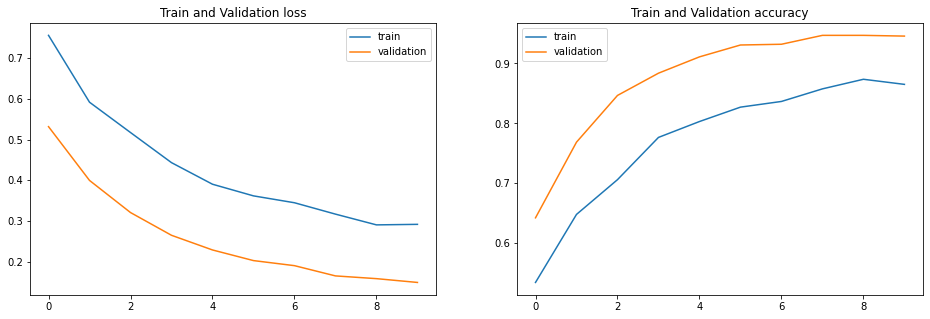

In [23]:
index = 0
plt.figure(figsize=(16,5))
for metric in ['loss', 'accuracy']:
  index += 1
  plt.subplot(1,2,index)
  plt.plot(range(num_epochs), history.history[metric])
  plt.plot(range(num_epochs), history.history['val_'+metric])
  plt.title('Train and Validation '+metric)
  plt.legend(['train','validation'])


**Note: If you are wondering why the validation metrics are clearly better than the training metrics**
*  the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

* To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

**Note**: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## Un-freeze the top layers of the model
All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [24]:
base_model.trainable = True

In [25]:
# find out how many layers are there in mobile net v2
print('Number of layers in moblile net v2 :', len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in moblile net v2 : 154


## Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [26]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [28]:
print('Number of trainable variables',len(model.trainable_variables))

Number of trainable variables 56


## Continue training the model
**If you trained to convergence earlier, this step will improve your accuracy by a few percentage points**.

In [29]:
total_epochs = num_epochs + 10
fine_history = model.fit(train_ds, epochs=total_epochs, validation_data=val_ds, initial_epoch=history.epoch[-1])

Epoch 10/20
63/63 [==============================] - 75s 1s/step - loss: 0.2160 - accuracy: 0.9015 - val_loss: 0.0715 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 71s 1s/step - loss: 0.1838 - accuracy: 0.9250 - val_loss: 0.0608 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 68s 1s/step - loss: 0.1544 - accuracy: 0.9365 - val_loss: 0.0625 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 70s 1s/step - loss: 0.1209 - accuracy: 0.9505 - val_loss: 0.0567 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 69s 1s/step - loss: 0.1133 - accuracy: 0.9515 - val_loss: 0.0709 - val_accuracy: 0.9752
Epoch 15/20
63/63 [==============================] - 71s 1s/step - loss: 0.1246 - accuracy: 0.9520 - val_loss: 0.0444 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 71s 1s/step - loss: 0.0958 - accuracy: 0.9575 - val_loss: 0.0516 - val_accuracy: 0.9876
Epoch 17/20
6

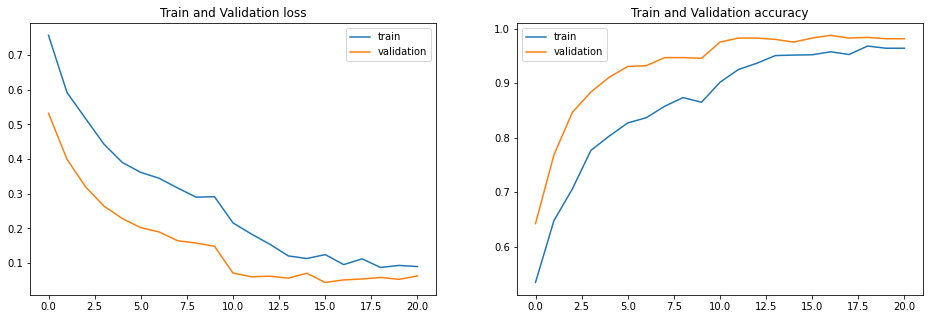

In [32]:
index = 0
plt.figure(figsize=(16,5))
for metric in ['loss', 'accuracy']:
  index += 1
  plt.subplot(1,2,index)
  plt.plot(range(total_epochs+1), history.history[metric]+fine_history.history[metric])
  plt.plot(range(total_epochs+1), history.history['val_'+metric]+fine_history.history['val_'+metric])
  plt.title('Train and Validation '+metric)
  plt.legend(['train','validation'])

## Evaluation and prediction
Finaly you can verify the performance of the model on new data using test set.

In [33]:
loss, accuracy = model.evaluate(test_ds)
print('Loss', loss)
print('Accuracy', accuracy)

63/63 [==============================] - 27s 430ms/step - loss: 0.0365 - accuracy: 0.9900
Loss 0.03645977005362511
Accuracy 0.9900000095367432


In [43]:
# retrieve a batch of test images
test_image_batch , test_image_label = next(iter(test_ds))

In [44]:
# model prediction
predictions = model.predict(test_image_batch)

In [60]:
# apply sigmoid activation
predicted_labels = tf.nn.sigmoid(predictions)

In [62]:
predicted_labels = tf.where(predicted_labels.numpy().flatten() > 0.5, 1, 0)

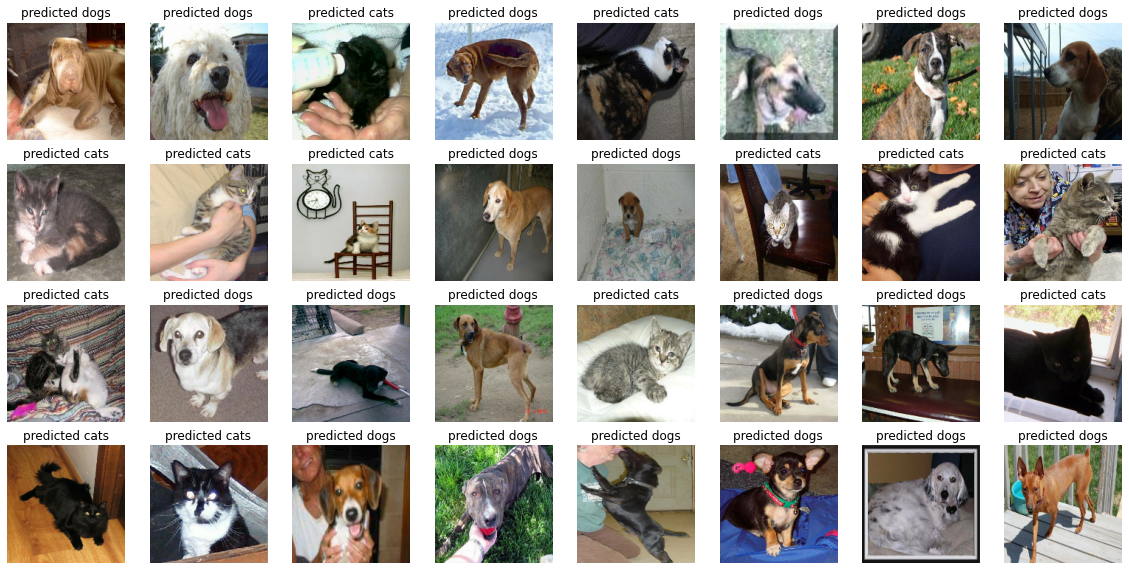

In [74]:
plt.figure(figsize=(20,20))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(test_image_batch[i].numpy().astype('uint8'))
  plt.axis('off')
  plt.title('predicted '+raw_train_ds.class_names[predicted_labels[i]])
  plt.subplots_adjust(top=0.5)
plt.show()

## Summary
* Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.